# **Importing required libaries**

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# **Importing our data from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
user_good = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/user_good.csv")
user_bad = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/user_bad.csv")
df = pd.concat([user_good,user_bad])
df.head()

# **Data analysis**
What is the correlation between different features in this dataset?

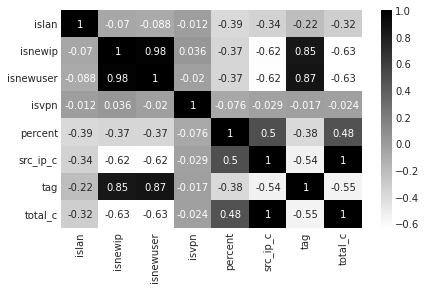

In [22]:
sns.heatmap(df.corr(), annot=True, cmap='binary')

Lets try understand the data distribution of different features using histograms.

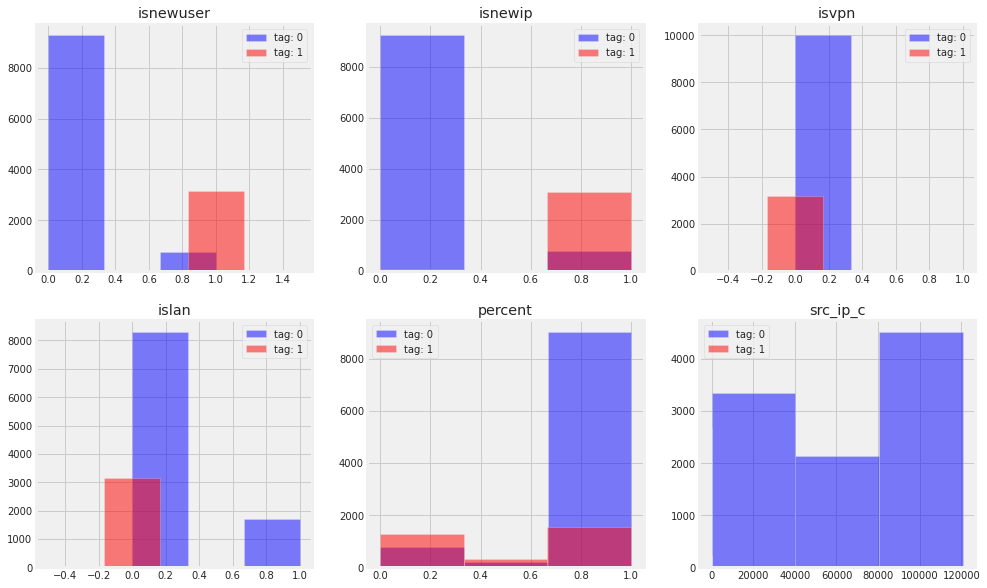

In [32]:
df1 = pd.DataFrame(df, columns=["isnewuser", "isnewip", "isvpn", "islan", "percent", "src_ip_c", "tag"])

# separate the data into two dataframes based on the label
df_0 = df[df['tag']==0]
df_1 = df[df['tag']==1]

# create histograms for each feature for each label
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs = axs.ravel()
for i, feature in enumerate(["isnewuser", "isnewip", "isvpn", "islan", "percent", "src_ip_c"]):
    axs[i].hist(df_0[feature], bins=3, alpha=0.5, label='tag: 0', color='blue')
    axs[i].hist(df_1[feature], bins=3, alpha=0.5, label='tag: 1', color='red')
    axs[i].set_title(feature)
    axs[i].legend()

plt.show()

From our correlation matrix and histogram we have identified two features of interset to futher examine, "isnewip" and "isnewuser". Lets use violin graphs to plot these features.

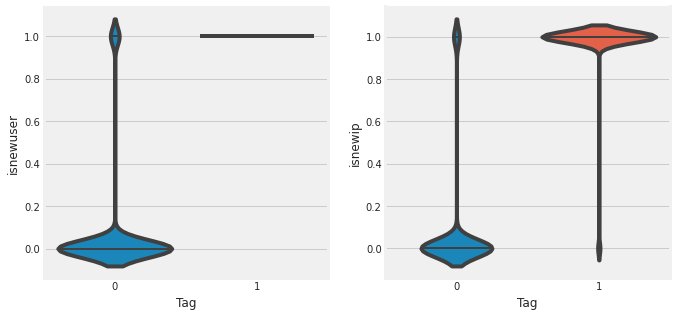

In [35]:
# Creating a figure object
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Creating violin plots for both features in the same figure
sns.violinplot(x='tag', y='isnewuser', data=df, inner='stick', split=True, ax=axs[0])
sns.violinplot(x='tag', y='isnewip', data=df, inner='stick', split=True, ax=axs[1])

# Labeling the x-axis and y-axis
axs[0].set_xlabel('Tag')
axs[0].set_ylabel('isnewuser')
axs[1].set_xlabel('Tag')
axs[1].set_ylabel('isnewip')

# Displaying the figure
plt.show()

# **KNN Model**

In [ ]:
feature_cols = ['isnewuser','isnewip','isvpn','islan','percent','src_ip_c']
X = df[feature_cols]
y = df['tag']
# train and split data for testing 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)
k_range= range(1,26)
scores = []
# Finding the best K 
for k in k_range: 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.f1_score(y_test, y_pred))
  
    targetname = ['Normal','Malicious']
    result = metrics.classification_report(y_test,y_pred,target_names=targetname)
    matrix = metrics.confusion_matrix(y_test, y_pred, labels = [0,1]) 
    print ('Currently running K:' + str(k))
    print (result)
    print (matrix)
# Plotting as graph 
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

# **XGBoost model**

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# set up the XGBoost model
xgb = XGBClassifier()

# perform grid search to find the best hyperparameters
param_grid = {'max_depth': range(3,10,2),
              'min_child_weight': range(1,6,2),
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.8, 0.9],
              'n_estimators': [100, 500]
             }
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# make predictions on the test set
y_pred = grid_search.predict(X_test)

# calculate performance metrics
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("F1-score: %.2f" % f1)
print("Accuracy: %.2f" % acc)

F1-score: 1.00
Accuracy: 1.00


Lets plot the feature importance and descision tree.

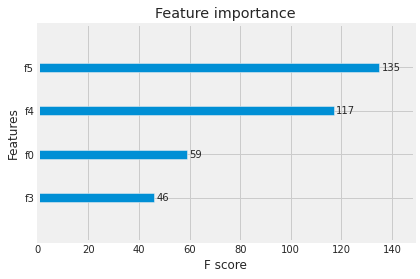

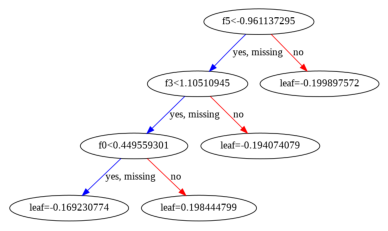

In [13]:
from xgboost import plot_importance, plot_tree

# fit the model on the training data
xgb.fit(X_train, y_train)

# plot feature importance
plot_importance(xgb)
plt.show()

# plot a single tree
plot_tree(xgb, num_trees=0)
plt.show()

# **ANN using gradient descent**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

# Train the model
mlp.fit(X_train, y_train)

# Plot the training loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f" % acc)
print(confusion_matrix(y_test, y_pred))



# **Conculsion**
The results of the model evaluations showed that all three models achieved very high F1 scores, with values greater than 0.99. This suggests that the models were able to accurately identify both malicious and non-malicious event logs.

Despite the high performance of these models, there are some limitations and issues to consider. One potential problem with the data is that was generated using simulated attacks, which may not fully reflect the complexity and diversity of real-world attacks. Additionally, the high performance of the models may be due to overfitting, as the data was generated and labeled by the same team. Therefore, it would be essential to test these models on real-world data, as well as additional unseen data, to ensure their robustness.

Another limitation is that the features used in this study were generated based on the simulated attacks and may not be generalizable to real-world attacks. It's important to note that the feature selection process could have an impact on the performance of the models and further research may be needed to identify the most informative and relevant features for this task.

In conclusion, the models trained in this study achieved very high F1 scores on the simulated data. However, further testing on real-world data is needed to confirm the robustness and generalizability of these models. Additionally, the feature selection process should be further investigated to ensure that the most informative and relevant features are being used.



